## Projet APST2 Reinforcement Part 2: Reinforcment applied to the Pendulum problem

#### Roig Sébastien, Defossez Floran, Chopard Gatien, Gougeon Natacha

In [1]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

## The Pendulum

In [2]:
env = gym.make("Pendulum-v1")
print(f'action space: {env.action_space}')
print(f'observation space: {env.observation_space}')

action space: Box(-2.0, 2.0, (1,), float32)
observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


### Description
The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.


Pendulum Coordinate System used for the implementation of the pendulum’s dynamic equations.

- x and y: cartesian coordinates of the pendulum’s end in meters.
- $\theta$: angle in radians.
- $\tau$: torque in N m. Defined as positive counter-clockwise.

### Action Space
The action is a ndarray with shape (1,) representing the torque applied to free end of the pendulum.
The torque must be in [-2,2]


### Observation Space
The observation is a ndarray with shape (3,) representing the x-y coordinates of the pendulum’s free end and its angular velocity.

- $x = cos(\theta)\\$
- $y = sin(\theta)\\$
- $\dot{\theta} = \frac{d\theta}{dt} \in [-8,8]$


### Rewards
The reward function is defined as:

$$r = -(\theta^2 + 0.1 * \dot{\theta}^2 + 0.001 * \text{torque}^2)$$

where $\theta$ is the pendulum’s angle normalized between $[-\pi, \pi]$ (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is $-(\pi^2 + 0.1 * 82 + 0.001 * 22) = -16.27$, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

### Starting State
The starting state is a random angle in $[-\pi, \pi]$ and a random angular velocity in $[-1,1]$.

### Episode Truncation
The episode truncates at 200 time steps.

## Reinforce with gradient policy

We propose to build a policy using a deterministic gradient policy agrithm.

$$\pi(x) = 2*tanh(f(x)^\top a)$$
$$ f((x,y, \dot{\theta})) = ((x,y, \dot{\theta})1_{x<\alpha}, (x,y, \dot{\theta})1_{x>\alpha}) $$

The idea is to create two regimes, one for low pendulum positions which aims to bring it back in high position. And a regime of pendulum in high position which aims to stabilize. In this model, we have 8 parameters.

In [5]:
class Reinforcement:
    def __init__(self, n_episode, eta=0.001, gamma=0.9, alpha=0):
        self.n_episode = n_episode
        self.eta = eta
        self.gamma = gamma
        self.alpha = alpha

        self.policy = {
            "p": np.random.normal(0,10,size=3),
            "n": np.random.normal(0,10,size=3)
        }

    def act(self,x):
        if x[0] < self.alpha:
            a = 2*np.tanh(np.dot(x,self.policy["n"]))
        else:
            a = 2*np.tanh(np.dot(x,self.policy["p"]))
        return a

    
    def train(self):
        env = gym.make("Pendulum-v1")
        
        history = np.zeros(self.n_episode)

        gammas = np.zeros(200)
        gammas[0] = self.gamma
        for j in range(1,200):
            gammas[j] = self.gamma*gammas[j-1]
        
        grads = np.zeros((200,3))
        rewards = np.zeros(200)
        states = np.zeros((200,3))
        
        for i in range(self.n_episode):
            T = 0
            x = env.reset()
            state = x[0]
            truncated = False

            while not truncated:
                if np.random.rand() > np.exp(-0.001*i):
                    action = np.random.rand()*4 - 2
                else:
                    action = self.act(state)

                x, reward, done, truncated, info = env.step([action])

                rewards[T] = reward
                states[T] = x
                if x[0] < self.alpha:
                    grads[T] = self.policy["n"]*(1-np.tanh(np.dot(self.policy["n"],x))**2)/np.tanh(np.dot(self.policy["n"],state))
                else:
                    grads[T] = self.policy["p"]*(1-np.tanh(np.dot(self.policy["p"],x))**2)/np.tanh(np.dot(self.policy["p"],state))
                T += 1
                state = x
            
            for t in range(200):
                G = np.sum(rewards[t:T]* gammas[0:T-t])
                if states[t][0] < self.alpha:
                    self.policy["n"] += self.eta*G*grads[t]
                else:
                    self.policy["p"] += self.eta*G*grads[t]
            
            history[i] = np.sum(rewards)
        
        return history

We train the model with an $\epsilon$-greedy strategy over 100 episodes. It is necessary to execute several times the training to obtain convincing results, it seems that the method is rather unstable. We display below the evolution of the sum of the rewards of each episode during the training

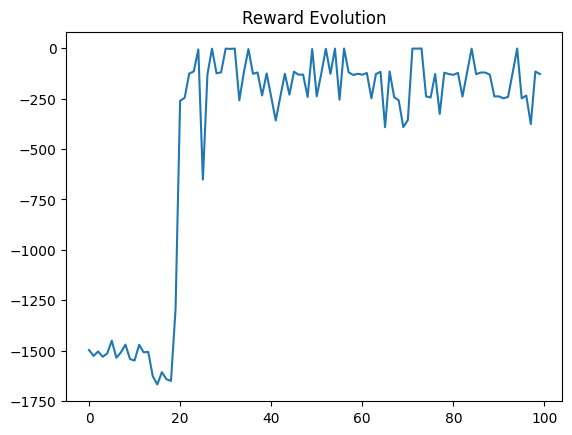

In [15]:
model = Reinforcement(100, 0.001, 0.99, 0)
history = model.train()

plt.plot(history)
plt.title("Reward Evolution")
plt.show()

We can play our strategy with the code below

In [13]:
# Use our policy
model.policy = {
    'p': np.array([  1.15585942, -29.76201472,  -6.01865807]),
    'n': np.array([298.53155851, 685.38216394, 669.7627977 ])
}

env = gym.make("Pendulum-v1", render_mode='human')
truncated = False
x = env.reset()[0]
env.render()
while not truncated:
    action = model.act(x)
    x, reward, done, truncated, info = env.step([action])
env.close()

Also, we can save a game with matplotlib and keep an gif image

In [ ]:
from matplotlib.animation import FuncAnimation

env = gym.make("Pendulum-v1", render_mode='rgb_array')
rewards = np.zeros(200)
states = np.zeros((200,3))
x = env.reset()[0]
env.render()

fig, ax = plt.subplots()
ax.axis("off")
ln = ax.imshow(np.ones((500,500,4)))

def update(frame):
    global x
    action = model.act(x)
    x, reward, done, truncated, info = env.step([action])
    states[frame] = x
    rewards[frame] = reward
    image = env.render()
    ln.set_data(image[100:-100,100:-100,:])
    return ln,

ani = FuncAnimation(fig, update, frames=range(200))
ani.save("./movie.gif", fps=20)
env.close()

<img src="movie.gif"/>

For that game, we display the rewards and the states 

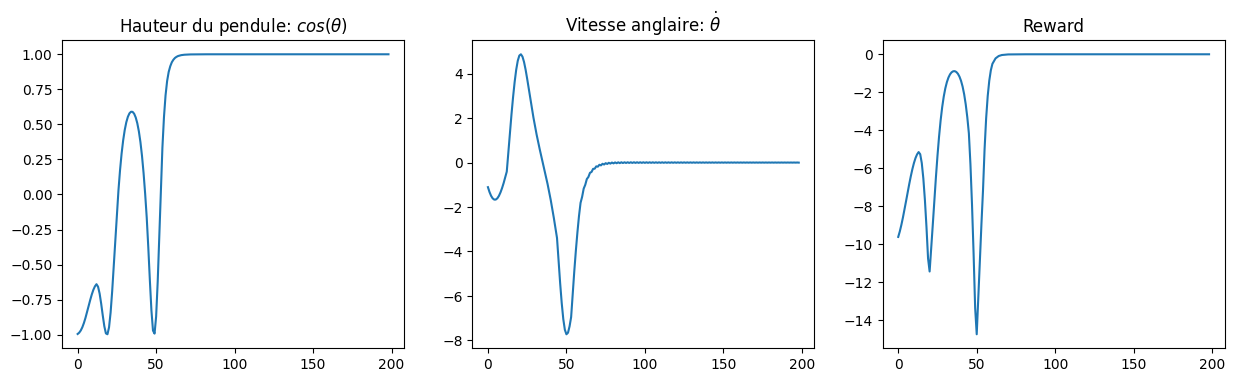

In [81]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.plot(states[1:,0])
ax1.set_title(r"Hauteur du pendule: $cos(\theta)$")
ax2.plot(states[1:,2])
ax2.set_title(r"Vitesse anglaire: $\dot{\theta}$")
ax3.plot(rewards[1:])
ax3.set_title("Reward")
plt.show()

We have here the policy that gave our results

In [82]:
model.policy

{'p': array([  1.15585942, -29.76201472,  -6.01865807]),
 'n': array([298.53155851, 685.38216394, 669.7627977 ])}